In [1]:
"""Will mainly follow Brain's Cell paper
GP is trained and validated on wt1-wt2 pairs first
Then wt1-mutant pairs are considered as the "unknown" and need ranking system
For Kd > 10000 nM, the pair is no longer considered as binding
"""
import torch
import esm
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from umap import UMAP
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_hdf('reduced_proteins_embeddings_meta.hdf', key='df')
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)
df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)
df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

#Pdb Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I           LI45G         5.260000e-11        1.120000e-12   
1     1CSE_E_I           LI45S         8.330000e-12        1.120000e-12   
2     1CSE_E_I           LI45P         1.020000e-07        1.120000e-12   
3     1CSE_E_I           LI45I         1.720000e-10        1.120000e-12   
4     1CSE_E_I           LI45D         1.920000e-09        1.120000e-12   
...        ...             ...                  ...                 ...   
2021  2WPT_A_B           FB86A         7.410000e-05        8.200000e-07   
2022  2WPT_A_B     DA33A,FB86A         6.210000e-07        8.200000e-07   
2023  2WPT_A_B           NA34A         6.490000e-07        8.200000e-07   
2024  2WPT_A_B           SB84A         7.090000e-07        8.200000e-07   
2025  2WPT_A_B     SB84A,NA34A         3.920000e-07        8.200000e-07   

                        Protein_1                    Protein_2  \
0            Subtilisin Carlsberg                      Eglin c   
1            Subtilisin Carlsberg                      Eglin c   
2            Subtilisin Carlsberg                      Eglin c   
3            Subtilisin Carlsberg                      Eglin c   
4            Subtilisin Carlsberg                      Eglin c   
...                           ...                          ...   
2021  Colicin E2 immunity protein             Colicin E9 DNase   
2022  Colicin E2 immunity protein             Colicin E9 DNase   
2023             Colicin E9 DNase  Colicin E2 immunity protein   
2024  Colicin E2 immunity protein             Colicin E9 DNase   
2025             Colicin E9 DNase  Colicin E2 immunity protein   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2021  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2022  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2023  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2024  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2025  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...          -4.503866   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.277973   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...           0.233872   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.145449   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDA

In [3]:
# handle Kd results, first, all Kd is multiplied by 10**9 to be nM, several other modifications:
# 1. any reads > 10000. are converted into 10000.
# 2. if after conversion, mut and wt affinity both have 10000., remove that row (both cases no binding)
# 3. if mut is NaN, wt is 10000., remove that row (both cases no binding)
# 4. if mut is NaN, wt is not 10000., change NaN to 10000. (NaN indicating no binding)
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
for col in ['Affinity_mut_parsed', 'Affinity_wt_parsed']:
    df.loc[df[col] > 10000, col] = 10000.
# Drop rows where both columns contain 10000
df = df.drop(df[(df['Affinity_mut_parsed'] == 10000.) & (df['Affinity_wt_parsed'] == 10000.)].index)
# Drop rows where one column is NaN and the other is 10000
df = df.drop(df[((df['Affinity_mut_parsed'].isna()) & (df['Affinity_wt_parsed'] == 10000.)) | ((df['Affinity_wt_parsed'].isna()) & (df['Affinity_mut_parsed'] == 10000.))].index)

# Modify NaN in 'col1' when 'col2' is not 10000, and vice-versa
for col, other_col in [('Affinity_mut_parsed', 'Affinity_wt_parsed'), ('Affinity_wt_parsed', 'Affinity_mut_parsed')]:
    mask = (df[col].isna()) & (df[other_col] != 10000.)
    df.loc[mask, col] = 10000.
df

#Pdb Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I           LI45G              0.05260             0.00112   
1     1CSE_E_I           LI45S              0.00833             0.00112   
2     1CSE_E_I           LI45P            102.00000             0.00112   
3     1CSE_E_I           LI45I              0.17200             0.00112   
4     1CSE_E_I           LI45D              1.92000             0.00112   
...        ...             ...                  ...                 ...   
2021  2WPT_A_B           FB86A          10000.00000           820.00000   
2022  2WPT_A_B     DA33A,FB86A            621.00000           820.00000   
2023  2WPT_A_B           NA34A            649.00000           820.00000   
2024  2WPT_A_B           SB84A            709.00000           820.00000   
2025  2WPT_A_B     SB84A,NA34A            392.00000           820.00000   

                        Protein_1                    Protein_2  \
0            Subtilisin Carlsberg                      Eglin c   
1            Subtilisin Carlsberg                      Eglin c   
2            Subtilisin Carlsberg                      Eglin c   
3            Subtilisin Carlsberg                      Eglin c   
4            Subtilisin Carlsberg                      Eglin c   
...                           ...                          ...   
2021  Colicin E2 immunity protein             Colicin E9 DNase   
2022  Colicin E2 immunity protein             Colicin E9 DNase   
2023             Colicin E9 DNase  Colicin E2 immunity protein   
2024  Colicin E2 immunity protein             Colicin E9 DNase   
2025             Colicin E9 DNase  Colicin E2 immunity protein   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2021  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2022  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2023  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2024  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2025  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...          -4.503866   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.277973   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...           0.233872   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.145449   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDA

In [5]:
max_molar = df[['Affinity_wt_parsed', 'Affinity_mut_parsed']].max().max()
max_molar

10000.0

In [6]:
# construct wt training set, remove the duplicated wt1-wt2 entries
dt = df.copy()
dt.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
dt

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G               0.0526             0.00112   
6     1ACB_E_I              LI45G              45.5000             0.00149   
12    1SBN_E_I              RI45K               0.0320             0.05400   
13    1SIB_E_I              KI53R               0.0320             0.11000   
14    1Y1K_E_I              AI58T               0.0030             0.30000   
...        ...                ...                  ...                 ...   
2008  5UFE_A_B              QB27R              82.4000            50.30000   
2012  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
2014  5TAR_A_B      TA183A,KA184E           10000.0000          2300.00000   
2015  1KBH_A_B               QA3W              42.9000            34.00000   
2019  2KSO_A_B              RA56E            1700.0000          5200.00000   

                      Protein_1                     Protein_2  \
0          Subtilisin Carlsberg                       Eglin c   
6     Bovine alpha-chymotrypsin                       Eglin c   
12               Subtilisin BPN                       Eglin c   
13               Subtilisin BPN                       Eglin c   
14               Subtilisin BPN      Chymotrypsin inhibitor 2   
...                         ...                           ...   
2008                      K-Ras                       R11.1.6   
2012                      K-Ras                       R11.1.6   
2014                  PDE delta                         K-Ras   
2015                  CREB NCBD                          ACTR   
2019                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
6     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
12    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
13    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
14    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
2008  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
...                                                 ...                ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2019  HHHHHHSSGL

In [7]:
train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(train_wt['Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
y_test_wt_array = np.vstack(test_wt['Affinity_wt_parsed'].to_numpy())

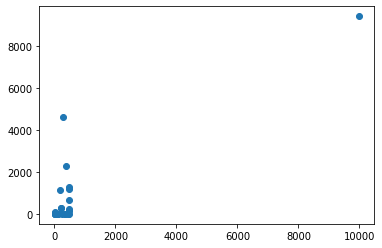

In [8]:
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(x_train_wt_array, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(x_test_wt_array, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

In [9]:
import scipy.stats as ss
ss.spearmanr(y_pred_wt, y_test_wt_array)

SpearmanrResult(correlation=0.5489517316395409, pvalue=0.004485807906261104)

In [10]:
ss.pearsonr(y_pred_wt, y_test_wt_array)

(array([0.874771566129521], dtype=object), 1.0758816423215211e-08)

In [62]:
from scipy.stats import rankdata
def acquisition_rank(y_pred, var_pred, beta=1.):
    print(y_pred.shape, var_pred.shape)
    return rankdata(y_pred) + (beta * rankdata(var_pred))

In [63]:
# assign ranking and uncertainties
acquisition = acquisition_rank(y_pred_wt, y_var_wt)
acquisition

(25,) (25,)


array([43., 46., 23., 20., 13., 45., 43., 20., 10., 26., 29., 35.,  8.,
       22., 39., 11.,  5., 46., 13., 20.,  3., 32., 32., 39., 27.])

In [175]:
# after examined that GP performance is ok for wts, use all wts are the training set for the process
# construct wt training set, remove the duplicated wt1-wt2 entries
dt_train = df.copy()
dt_train.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
x_train_wt_array = np.vstack(dt_train['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(dt_train['Affinity_wt_parsed'].to_numpy())
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
model = gpr.fit(x_train_wt_array, y_train_wt_array)
dt_train

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G               0.0526             0.00112   
6     1ACB_E_I              LI45G              45.5000             0.00149   
12    1SBN_E_I              RI45K               0.0320             0.05400   
13    1SIB_E_I              KI53R               0.0320             0.11000   
14    1Y1K_E_I              AI58T               0.0030             0.30000   
...        ...                ...                  ...                 ...   
2008  5UFE_A_B              QB27R              82.4000            50.30000   
2012  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
2014  5TAR_A_B      TA183A,KA184E           10000.0000          2300.00000   
2015  1KBH_A_B               QA3W              42.9000            34.00000   
2019  2KSO_A_B              RA56E            1700.0000          5200.00000   

                      Protein_1                     Protein_2  \
0          Subtilisin Carlsberg                       Eglin c   
6     Bovine alpha-chymotrypsin                       Eglin c   
12               Subtilisin BPN                       Eglin c   
13               Subtilisin BPN                       Eglin c   
14               Subtilisin BPN      Chymotrypsin inhibitor 2   
...                         ...                           ...   
2008                      K-Ras                       R11.1.6   
2012                      K-Ras                       R11.1.6   
2014                  PDE delta                         K-Ras   
2015                  CREB NCBD                          ACTR   
2019                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
6     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
12    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
13    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
14    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
2008  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
...                                                 ...                ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2019  HHHHHHSSGL

In [174]:
# construct predicting set, remove the duplicated wt1-mut entries
dt_mut = df.copy()
dt_mut.drop_duplicates(subset=['wild_seq_1', 'mutant_seq'], inplace=True)
unknown_array = np.vstack(dt_mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(dt_mut['Affinity_mut_parsed'].to_numpy())
y_pred_mut, y_var_mut = gpr.predict(unknown_array, return_std=True)
dt_mut

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G              0.05260             0.00112   
1     1CSE_E_I              LI45S              0.00833             0.00112   
2     1CSE_E_I              LI45P            102.00000             0.00112   
3     1CSE_E_I              LI45I              0.17200             0.00112   
4     1CSE_E_I              LI45D              1.92000             0.00112   
...        ...                ...                  ...                 ...   
2012  5UFQ_A_C  DA12G,QC27R,KC59G             82.40000             6.40000   
2014  5TAR_A_B      TA183A,KA184E          10000.00000          2300.00000   
2015  1KBH_A_B               QA3W             42.90000            34.00000   
2016  1KBH_A_B              LA37W            143.00000            34.00000   
2019  2KSO_A_B              RA56E           1700.00000          5200.00000   

                 Protein_1                     Protein_2  \
0     Subtilisin Carlsberg                       Eglin c   
1     Subtilisin Carlsberg                       Eglin c   
2     Subtilisin Carlsberg                       Eglin c   
3     Subtilisin Carlsberg                       Eglin c   
4     Subtilisin Carlsberg                       Eglin c   
...                    ...                           ...   
2012                 K-Ras                       R11.1.6   
2014             PDE delta                         K-Ras   
2015             CREB NCBD                          ACTR   
2016             CREB NCBD                          ACTR   
2019             SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2016  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2016    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2016    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK          -1.436484   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030  

In [132]:
acquisition_unk = acquisition_rank(y_pred_mut, y_var_mut)

(1520,) (1520,)


In [133]:
def acquisition_scatter(y_unk_pred, var_unk_pred, acquisition):
    y_unk_pred = y_unk_pred[:]
    y_unk_pred[y_unk_pred > 10000] = 10000

    plt.figure()
    plt.scatter(y_unk_pred, var_unk_pred, alpha=0.5, c=-acquisition,
                cmap='hot')
    plt.xlabel('Predicted score')
    plt.ylabel('Variance')
    plt.show()

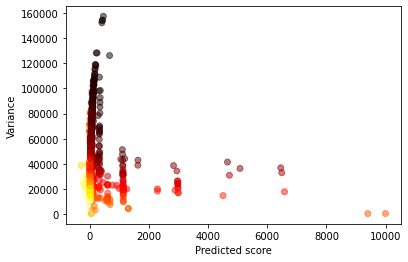

In [134]:
acquisition_scatter(y_pred_mut, y_var_mut, acquisition_unk)

In [135]:
# draw other types of visualization

In [136]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(x_train_wt_array)
dist = np.ravel(nbrs.kneighbors(unknown_array)[0])

In [137]:
whos_my_nbr = np.ravel(nbrs.kneighbors(unknown_array)[1])

In [138]:
ss.spearmanr(y_var_mut, dist)

SpearmanrResult(correlation=0.998317793395657, pvalue=0.0)

In [139]:
ss.pearsonr(y_var_mut, dist)

(0.9757663497008853, 0.0)

In [140]:
# stack the known and unknown arrays together
X = np.vstack([x_train_wt_array, unknown_array])

In [141]:
from umap import UMAP
um = UMAP(
        n_neighbors=15,
        min_dist=0.5,
        n_components=2,
        metric='euclidean',
    )
X_umap = um.fit_transform(X)

In [142]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(
        n_components=2,
        n_jobs=20,
    )
X_tsne = tsne.fit_transform(X)

In [144]:
# training data points are labeled as 0 and unknown data points are labeled as 1
labels = np.concatenate([
        np.zeros(len(x_train_wt_array)), np.ones(len(unknown_array))
    ])

In [149]:
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

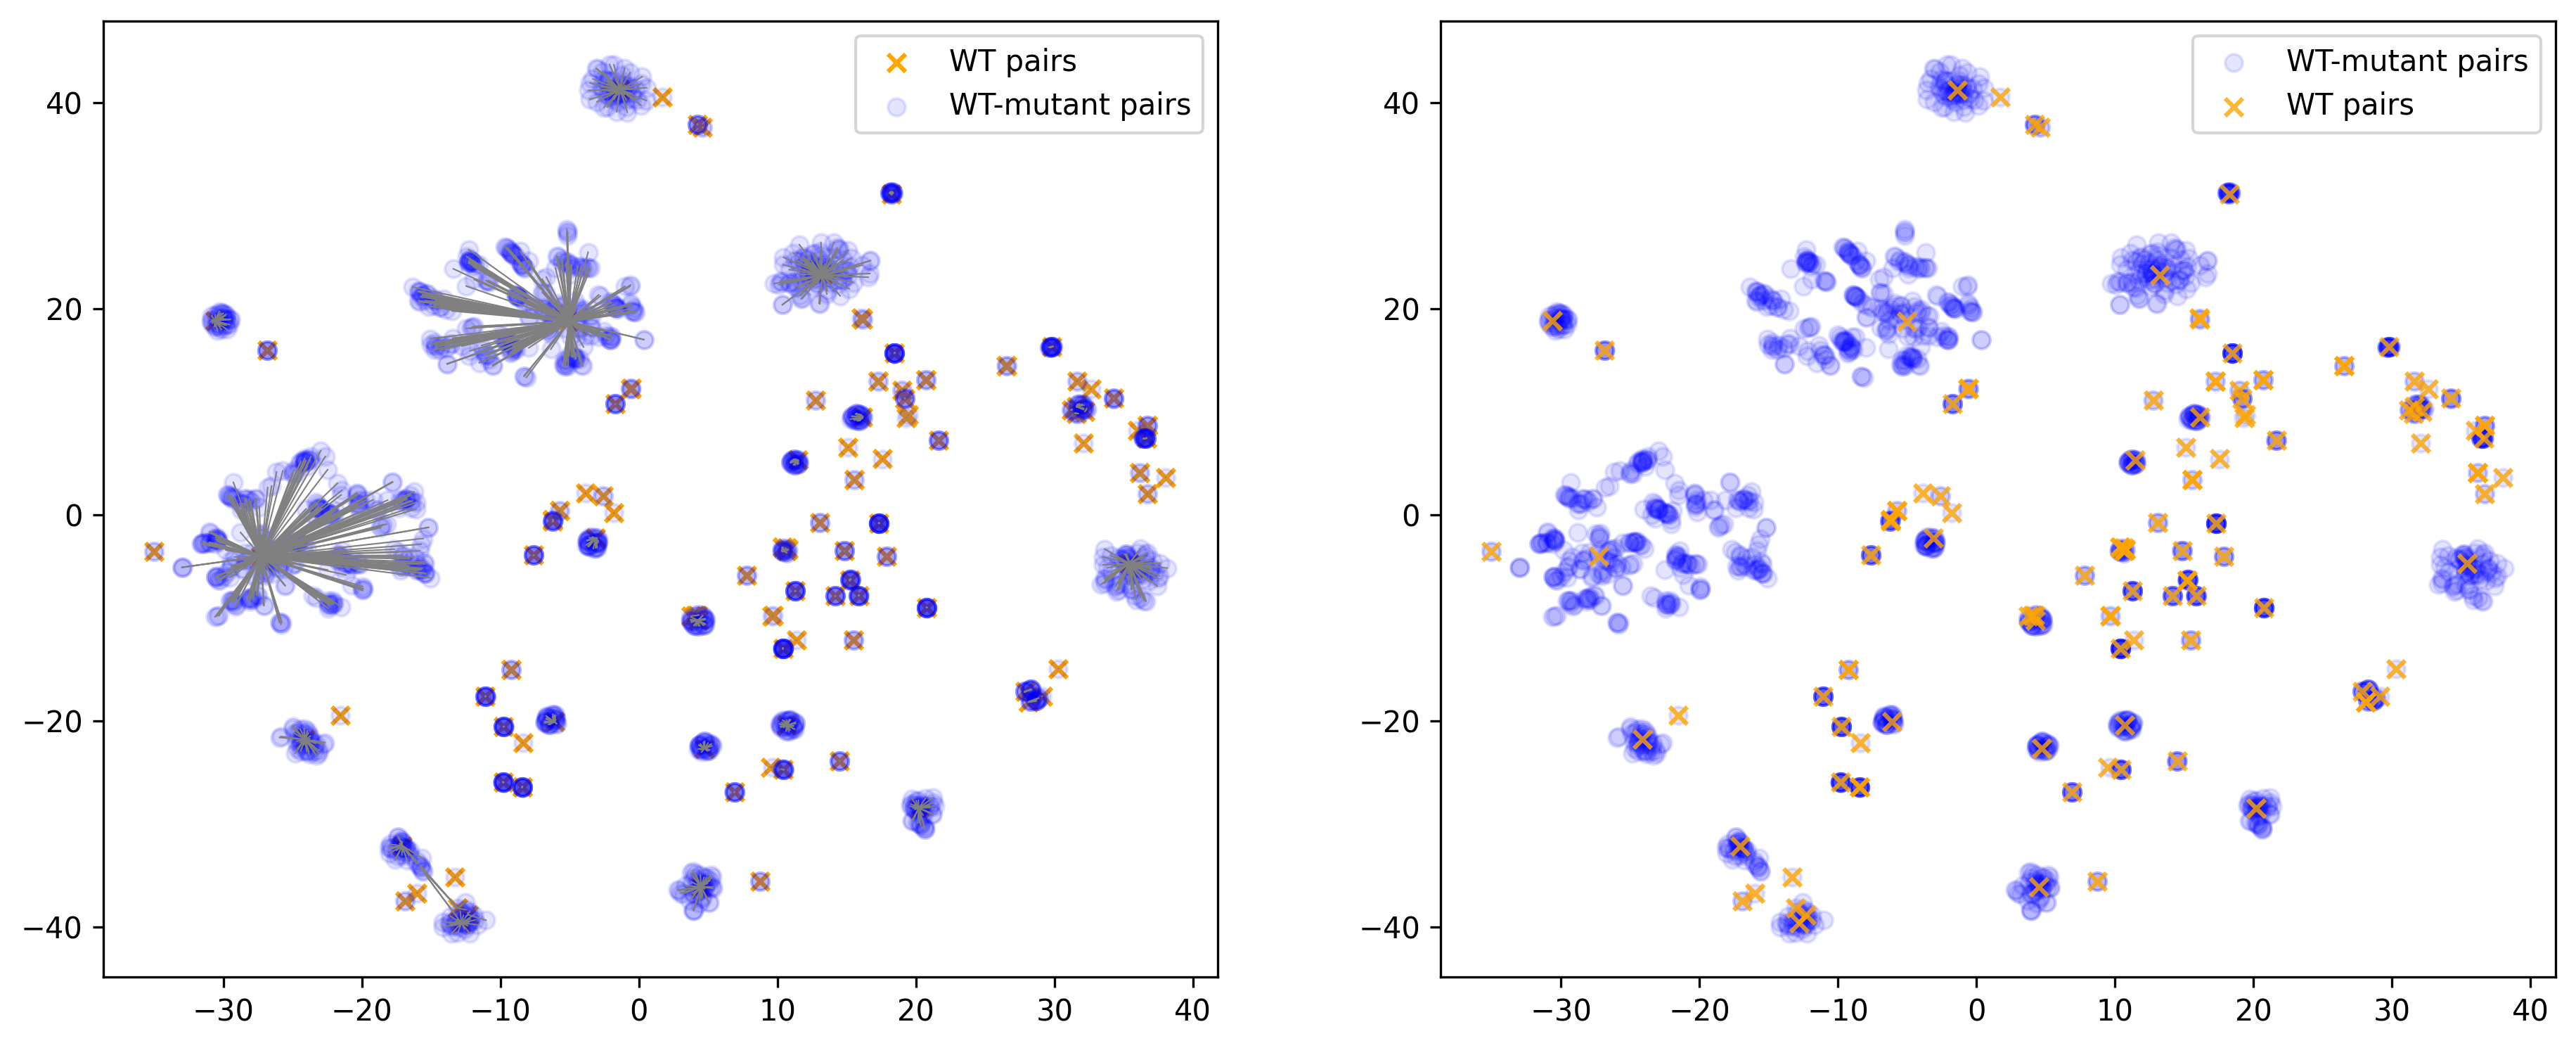

In [177]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), dpi=300)
ax1.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='orange', marker='x', label='WT pairs')
ax1.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue',  alpha=0.1, label='WT-mutant pairs')
for i, index in enumerate(whos_my_nbr):
    ax1.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)
ax1.legend()
ax2.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue', alpha=0.1, label='WT-mutant pairs')
ax2.scatter(tsne_obs[:, 0], tsne_obs[:, 1],
            color='orange', alpha=0.8, marker='x', label='WT pairs')
ax2.legend()
fig.savefig('./outputs/figures/tsne_skempi_wt_mut.png')

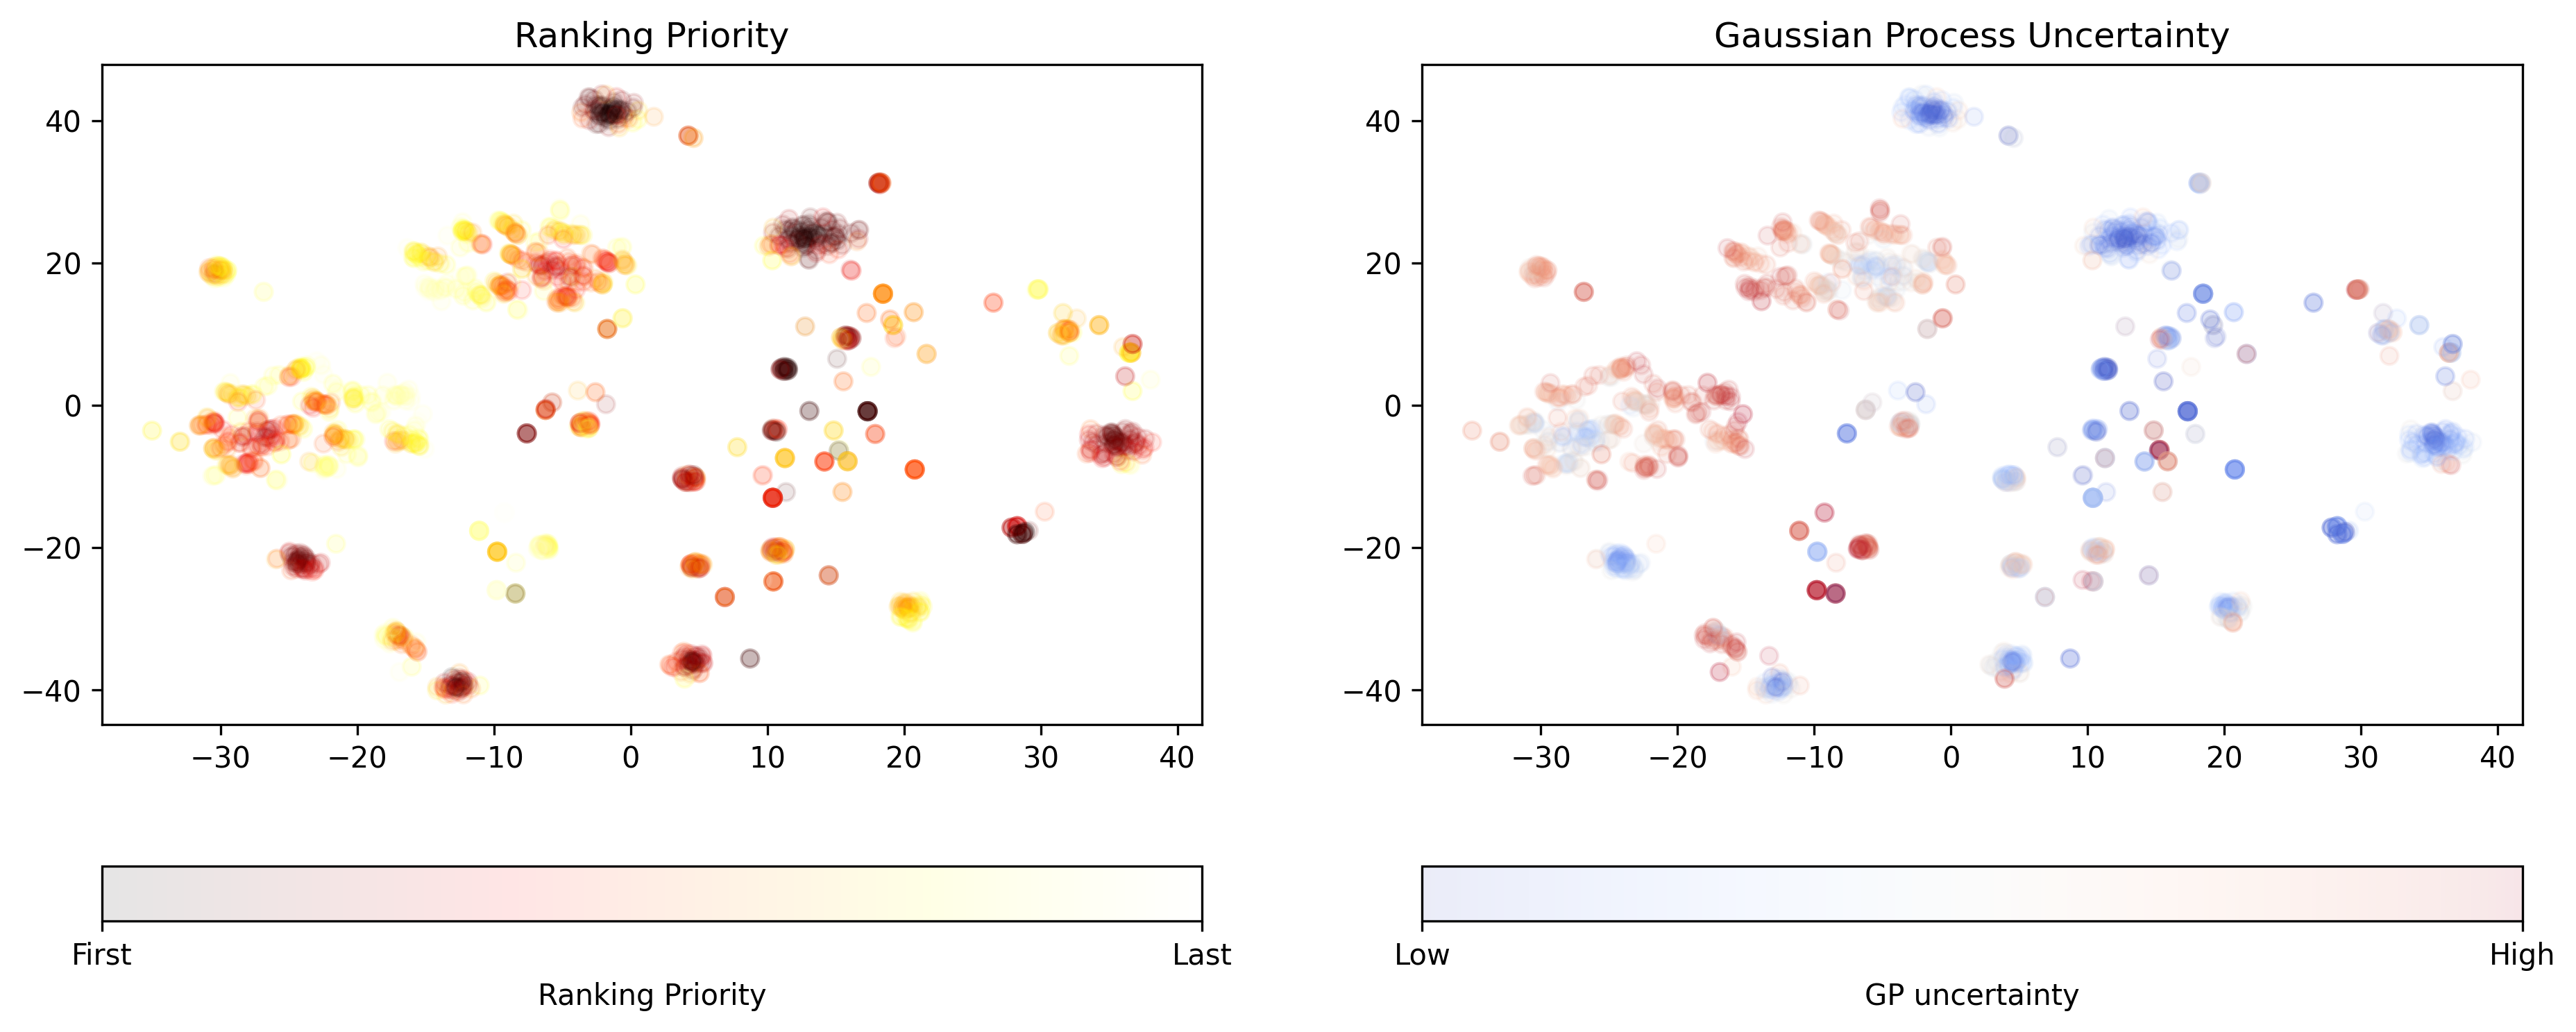

In [172]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), dpi=300)
scatter1 = ax1.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1],
            c=acquisition_unk, alpha=0.1, cmap='hot')
ax1.set_title('Ranking Priority')
# visualize the mutant based on the rank data of the GP variances (uncertainty)
scatter2 = ax2.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1],
            c=ss.rankdata(y_var_mut), alpha=0.1, cmap='coolwarm')
ax2.set_title('Gaussian Process Uncertainty')
cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='horizontal')
cbar1.set_ticks([acquisition_unk.min(), acquisition_unk.max()])
cbar1.set_ticklabels(['First',  'Last'])
cbar1.set_label('Ranking Priority')
cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='horizontal')
cbar2.set_ticks([ss.rankdata(y_var_mut).min(), ss.rankdata(y_var_mut).max()])
cbar2.set_ticklabels(['Low',  'High'])
cbar2.set_label('GP uncertainty')
fig.savefig('./outputs/figures/tsne_skempi_gp_rank.png')

In [189]:
# interactive plots showing actual points that reflect Kd changes
# add meta, using dict
dt_train = dt_train.reset_index(drop=True)
dt_train

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0    1CSE_E_I              LI45G               0.0526             0.00112   
1    1ACB_E_I              LI45G              45.5000             0.00149   
2    1SBN_E_I              RI45K               0.0320             0.05400   
3    1SIB_E_I              KI53R               0.0320             0.11000   
4    1Y1K_E_I              AI58T               0.0030             0.30000   
..        ...                ...                  ...                 ...   
117  5UFE_A_B              QB27R              82.4000            50.30000   
118  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
119  5TAR_A_B      TA183A,KA184E           10000.0000          2300.00000   
120  1KBH_A_B               QA3W              42.9000            34.00000   
121  2KSO_A_B              RA56E            1700.0000          5200.00000   

                     Protein_1                     Protein_2  \
0         Subtilisin Carlsberg                       Eglin c   
1    Bovine alpha-chymotrypsin                       Eglin c   
2               Subtilisin BPN                       Eglin c   
3               Subtilisin BPN                       Eglin c   
4               Subtilisin BPN      Chymotrypsin inhibitor 2   
..                         ...                           ...   
117                      K-Ras                       R11.1.6   
118                      K-Ras                       R11.1.6   
119                  PDE delta                         K-Ras   
120                  CREB NCBD                          ACTR   
121                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                            wild_seq_1  \
0    AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1    CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
..                                                 ...   
117  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
118  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
119  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
120  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
121  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                            wild_seq_2  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
..                                                 ...   
117  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
118  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
119  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
120    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
121  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                            mutant_seq  specificity_score  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
..                                                 ...                ...   
117  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
118  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
119  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
120    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
121  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030 

In [190]:
dt_train_with_tsne = pd.concat([dt_train, pd.DataFrame(tsne_obs)], axis=1)
new_columns = dt_train.columns.tolist() + ['wt_tsne_1', 'wt_tsne_2']
dt_train_with_tsne.columns = new_columns
dt_train_with_tsne

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0    1CSE_E_I              LI45G               0.0526             0.00112   
1    1ACB_E_I              LI45G              45.5000             0.00149   
2    1SBN_E_I              RI45K               0.0320             0.05400   
3    1SIB_E_I              KI53R               0.0320             0.11000   
4    1Y1K_E_I              AI58T               0.0030             0.30000   
..        ...                ...                  ...                 ...   
117  5UFE_A_B              QB27R              82.4000            50.30000   
118  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
119  5TAR_A_B      TA183A,KA184E           10000.0000          2300.00000   
120  1KBH_A_B               QA3W              42.9000            34.00000   
121  2KSO_A_B              RA56E            1700.0000          5200.00000   

                     Protein_1                     Protein_2  \
0         Subtilisin Carlsberg                       Eglin c   
1    Bovine alpha-chymotrypsin                       Eglin c   
2               Subtilisin BPN                       Eglin c   
3               Subtilisin BPN                       Eglin c   
4               Subtilisin BPN      Chymotrypsin inhibitor 2   
..                         ...                           ...   
117                      K-Ras                       R11.1.6   
118                      K-Ras                       R11.1.6   
119                  PDE delta                         K-Ras   
120                  CREB NCBD                          ACTR   
121                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                            wild_seq_1  \
0    AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1    CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
..                                                 ...   
117  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
118  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
119  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
120  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
121  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                            wild_seq_2  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
..                                                 ...   
117  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
118  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
119  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
120    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
121  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                            mutant_seq  specificity_score  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
..                                                 ...                ...   
117  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
118  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
119  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
120    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
121  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030 

In [205]:
dict_train_with_tsne = {}
for _, row in dt_train_with_tsne.iterrows():
    key = (row['wild_seq_1'], row['wild_seq_2'])
    sub_dict = {
        'PDB': row['#Pdb'],
        'PPI': row['Protein_1'] + '___' + row['Protein_2'],
        'Protein_1': row['Protein_1'],
        'Protein_2': row['Protein_2'],
        'wild_seq_1': row['wild_seq_1'],
        'wild_seq_2': row['wild_seq_2'],
        'wild_seq_1_embeddings': row['wild_seq_1_embeddings'],
        'wild_seq_2_embeddings': row['wild_seq_2_embeddings'],
        'combined_embeddings': row['wt1_wt2_concat'],
        'label': 'wt_pairs',
        'Affinity_wt_parsed': row['Affinity_wt_parsed'],
        'tsne_1': row['wt_tsne_1'],
        'tsne_2': row['wt_tsne_2'],
    }
    dict_train_with_tsne[key] = sub_dict
dict_train_with_tsne

{('AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNHVPHVG'): {'PDB': '1CSE_E_I',
  'PPI': 'Subtilisin Carlsberg___Eglin c',
  'Protein_1': 'Subtilisin Carlsberg',
  'Protein_2': 'Eglin c',
  'wild_seq_1': 'AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'wild_seq_2': 'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNHVPHVG',
  'wild_seq_1_embeddings': array([[-0.03216694, -0.15676358, -0.00066792, ..., -0.20720087,
          -0.00166783,  0.07189757]], d

In [214]:
dt_mut = dt_mut.reset_index(drop=True)
dt_pred_with_tsne = pd.concat([dt_mut, pd.DataFrame(tsne_unknown), pd.DataFrame(y_pred_mut), pd.DataFrame(y_var_mut), pd.DataFrame(acquisition_unk)], axis=1)
new_columns = dt_mut.columns.tolist() + ['mut_tsne_1', 'mut_tsne_2', 'y_pred_mut', 'y_var_mut', 'acquisition']
dt_pred_with_tsne.columns = new_columns
dt_pred_with_tsne

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G              0.05260             0.00112   
1     1CSE_E_I              LI45S              0.00833             0.00112   
2     1CSE_E_I              LI45P            102.00000             0.00112   
3     1CSE_E_I              LI45I              0.17200             0.00112   
4     1CSE_E_I              LI45D              1.92000             0.00112   
...        ...                ...                  ...                 ...   
1515  5UFQ_A_C  DA12G,QC27R,KC59G             82.40000             6.40000   
1516  5TAR_A_B      TA183A,KA184E          10000.00000          2300.00000   
1517  1KBH_A_B               QA3W             42.90000            34.00000   
1518  1KBH_A_B              LA37W            143.00000            34.00000   
1519  2KSO_A_B              RA56E           1700.00000          5200.00000   

                 Protein_1                     Protein_2  \
0     Subtilisin Carlsberg                       Eglin c   
1     Subtilisin Carlsberg                       Eglin c   
2     Subtilisin Carlsberg                       Eglin c   
3     Subtilisin Carlsberg                       Eglin c   
4     Subtilisin Carlsberg                       Eglin c   
...                    ...                           ...   
1515                 K-Ras                       R11.1.6   
1516             PDE delta                         K-Ras   
1517             CREB NCBD                          ACTR   
1518             CREB NCBD                          ACTR   
1519             SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
1515  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1516  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
1517  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1518  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1519  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
1515  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
1516  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1517    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
1518    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
1519  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
1515  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
1516  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
1517    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
1518    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK          -1.436484   
1519  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030  

In [212]:
y_pred_mut

array([  23.8460462 ,   12.51056909,   16.31911286, ...,  243.75221808,
        202.00067865, 5077.54886866])

In [215]:
dict_pred_with_tsne = {}
for _, row in dt_pred_with_tsne.iterrows():
    key = (row['wild_seq_1'], row['mutant_seq'])
    sub_dict = {
        'PDB': row['#Pdb'],
        'PPI': row['Protein_1'] + '___' + row['Protein_2'],
        'Protein_1': row['Protein_1'],
        'Protein_2': row['Protein_2']+'_mutant',
        'wild_seq_1': row['wild_seq_1'],
        'mutant_seq': row['mutant_seq'],
        'wild_seq_1_embeddings': row['wild_seq_1_embeddings'],
        'mutant_seq_embeddings': row['mutant_seq_embeddings'],
        'combined_embeddings': row['wt1_mut_concat'],
        'label': 'mutant_pairs',
        'Affinity_mut_parsed': row['Affinity_mut_parsed'],
        'tsne_1': row['mut_tsne_1'],
        'tsne_2': row['mut_tsne_2'],
        'specificity_score': row['specificity_score'],
        'Mutation(s)_PDB': row['Mutation(s)_PDB'],
        'y_pred_mut': row['y_pred_mut'],
        'y_var_mut': row['y_var_mut'],
        'acquisition': row['acquisition'],
    }
    dict_pred_with_tsne[key] = sub_dict
dict_pred_with_tsne

{('AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNHVPHVG'): {'PDB': '1CSE_E_I',
  'PPI': 'Subtilisin Carlsberg___Eglin c',
  'Protein_1': 'Subtilisin Carlsberg',
  'Protein_2': 'Eglin c_mutant',
  'wild_seq_1': 'AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'mutant_seq': 'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNHVPHVG',
  'wild_seq_1_embeddings': array([[-0.03216694, -0.15676358, -0.00066792, ..., -0.20720087,
          -0.00166783,  0.071897

In [216]:
df1 = pd.DataFrame.from_dict(dict_train_with_tsne, orient='index')
df1

PDB  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...  1CSE_E_I   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  1ACB_E_I   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...  1SBN_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  1SIB_E_I   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...  1Y1K_E_I   
...                                                                                                         ...   
MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...  5UFE_A_B   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...  5UFQ_A_C   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...  5TAR_A_B   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK     1KBH_A_B   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  2KSO_A_B   

                                                                                                                                             PPI  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...             Subtilisin Carlsberg___Eglin c   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...        Bovine alpha-chymotrypsin___Eglin c   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...                   Subtilisin BPN___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...                   Subtilisin BPN___Eglin c   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...  Subtilisin BPN___Chymotrypsin inhibitor 2   
...                                                                                                                                          ...   
MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...                            K-Ras___R11.1.6   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...                            K-Ras___R11.1.6   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...                          PDE delta___K-Ras   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK                              CREB NCBD___ACTR   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...   SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                                                                                                                       Protein_1  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...       Subtilisin Carlsberg   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  Bovine alpha-chymotrypsin   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...             Subtilisin BPN   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...             Subtilisin BPN   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...             Subtilisin BPN   
...                                                                                                                          ...   
MTEYKLVVVGAGGVGKSALTIQLIQN

In [217]:
df2 = pd.DataFrame.from_dict(dict_pred_with_tsne, orient='index')
df2

PDB  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...  1CSE_E_I   
...                                                                                                         ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVSE...  5UFQ_A_C   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...  5TAR_A_B   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK     1KBH_A_B   
                                                   EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK     1KBH_A_B   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  2KSO_A_B   

                                                                                                                                            PPI  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...            Subtilisin Carlsberg___Eglin c   
...                                                                                                                                         ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVSE...                           K-Ras___R11.1.6   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...                         PDE delta___K-Ras   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK                             CREB NCBD___ACTR   
                                                   EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK                             CREB NCBD___ACTR   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                                                                                                                  Protein_1  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...  Subtilisin Carlsberg   
...                                                                                                                     ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWV

In [218]:
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined

PDB                                        PPI  \
0     1CSE_E_I             Subtilisin Carlsberg___Eglin c   
1     1ACB_E_I        Bovine alpha-chymotrypsin___Eglin c   
2     1SBN_E_I                   Subtilisin BPN___Eglin c   
3     1SIB_E_I                   Subtilisin BPN___Eglin c   
4     1Y1K_E_I  Subtilisin BPN___Chymotrypsin inhibitor 2   
...        ...                                        ...   
1637  5UFQ_A_C                            K-Ras___R11.1.6   
1638  5TAR_A_B                          PDE delta___K-Ras   
1639  1KBH_A_B                           CREB NCBD___ACTR   
1640  1KBH_A_B                           CREB NCBD___ACTR   
1641  2KSO_A_B   SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                      Protein_1                            Protein_2  \
0          Subtilisin Carlsberg                              Eglin c   
1     Bovine alpha-chymotrypsin                              Eglin c   
2                Subtilisin BPN                              Eglin c   
3                Subtilisin BPN                              Eglin c   
4                Subtilisin BPN             Chymotrypsin inhibitor 2   
...                         ...                                  ...   
1637                      K-Ras                       R11.1.6_mutant   
1638                  PDE delta                         K-Ras_mutant   
1639                  CREB NCBD                          ACTR_mutant   
1640                  CREB NCBD                          ACTR_mutant   
1641                  SHIP2 SAM  Ephrin type-A receptor 2 SAM_mutant   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
1637  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1638  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
1639  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1640  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1641  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4     MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
1637                                                NaN   
1638                                                NaN   
1639                                                NaN   
1640                                                NaN   
1641                                                NaN   

                                  wild_seq_1_embeddings  \
0     [[-0.032166936, -0.15676358, -0.00066792156, 0...   
1     [[-0.02408382, -0.07500525, 0.095739715, 0.091...   
2     [[-0.026620023, -0.12713915, -0.023718221, 0.1...   
3     [[-0.026620023, -0.12713915, -0.023718221, 0.1...   
4     [[-0.02423378, -0.12586969, -0.016004924, 0.14...   
...                                                 ...   
1637  [[0.03184991, 0.003854431, -0.122885644, -0.02...   
1638  [[0.054286197, 0.015738036, 0.044642806, -0.04...   
1639  [[0.025925077, -0.061314803, 0.01449632, -0.01...   
1640  [[0.025925077, -0.061314803, 0.01449632, -0.01...   
1641  [[0.09892652, -0.10285678, -0.119882435, 0.044...   

                                  wild_seq_2_embeddings  \
0     [[0.05527322, -0.029942056, 0.032425687, -0.05...   
1     [[0.055853, -0.026456483, 0.03352555, -0.05577...   
2     [[0.045640845, -0.022037255, 0.03265124, -0.05...   
3     [[0.049512647, -0.024531225, 0.041538414, -0

In [240]:
dict_combined = {**dict_train_with_tsne, **dict_pred_with_tsne}
dict_combined

{('AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNHVPHVG'): {'PDB': '1CSE_E_I',
  'PPI': 'Subtilisin Carlsberg___Eglin c',
  'Protein_1': 'Subtilisin Carlsberg',
  'Protein_2': 'Eglin c',
  'wild_seq_1': 'AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQ',
  'wild_seq_2': 'TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNHVPHVG',
  'wild_seq_1_embeddings': array([[-0.03216694, -0.15676358, -0.00066792, ..., -0.20720087,
          -0.00166783,  0.07189757]], d

In [232]:
def add_traces(fig, variant_meta, index):
    import plotly.graph_objs as go
    fig.add_trace(go.Scatter(
        x=[variant_meta[index]['tsne_1']],
        y=[variant_meta[index]['tsne_2']],
        mode='markers',
        marker=dict(size=10, color='orange',
                        symbol='cross',
                        line=dict(width=2)),
        customdata=[variant_meta[index]['Affinity_wt_parsed']],
        hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                        f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                        f"<b>ppi:</b>{variant_meta[index]['PPI']}" +
                        '<extra></extra>',
        name='wt_pairs'
    ))
    return fig

In [256]:
def add_traces_mut(fig, variant_meta, index):
    import plotly.graph_objs as go
    if variant_meta[index]['label'] == 'wt_pairs':
        fig.add_trace(go.Scatter(
        x=[variant_meta[index]['tsne_1']],
        y=[variant_meta[index]['tsne_2']],
        mode='markers',
        marker=dict(size=10, color='rgb(242,183,1)',
                        symbol='x',),
        customdata=[variant_meta[index]['Affinity_wt_parsed']],
        hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                        f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                        f"<b>ppi:</b>{variant_meta[index]['PPI']}" +
                        '<extra></extra>',
        name='wt_pairs'
        ))
    elif variant_meta[index]['label'] == 'mutant_pairs':
        if variant_meta[index]['acquisition'] <= 300:
            fig.add_trace(go.Scatter(
                x=[variant_meta[index]['tsne_1']],
                y=[variant_meta[index]['tsne_2']],
                mode='markers',
                marker=dict(size=10, color='rgb(231, 138, 195)',
                        symbol='circle-dot',
                        line=dict(width=2)),
                customdata=[variant_meta[index]['Affinity_mut_parsed']],
                hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                                f"<b>specificity_score:</b>{variant_meta[index]['specificity_score']} <br>" +
                                f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                                f"<b>ppi:</b>{variant_meta[index]['PPI']} <br>" +
                                f"<b>mutation:</b>{variant_meta[index]['Mutation(s)_PDB']} <br>" +
                                f"<b>acquisition:</b>{variant_meta[index]['acquisition']} <br>" +
                                f"<b>uncertainties:</b>{variant_meta[index]['y_var_mut']} <br>" +
                                f"<b>protein_seq1:</b>{variant_meta[index]['wild_seq_1']} <br>" +
                                f"<b>mutant_seq2:</b>{variant_meta[index]['mutant_seq']}" +
                                '<extra></extra>',
                name='mut_high_priority'
        ))
        else:
            fig.add_trace(go.Scatter(
                x=[variant_meta[index]['tsne_1']],
                y=[variant_meta[index]['tsne_2']],
                mode='markers',
                marker=dict(size=5, opacity=0.8, color='rgba(135, 206, 250, 0.5)',),
                customdata=[variant_meta[index]['Affinity_mut_parsed']],
                hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                            f"<b>specificity_score:</b>{variant_meta[index]['specificity_score']} <br>" +
                            f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                            f"<b>ppi:</b>{variant_meta[index]['PPI']} <br>" +
                            f"<b>mutation:</b>{variant_meta[index]['Mutation(s)_PDB']} <br>" +
                            f"<b>acquisition:</b>{variant_meta[index]['acquisition']} <br>" +
                            f"<b>uncertainties:</b>{variant_meta[index]['y_var_mut']}" +
                            '<extra></extra>',
            name='mut_pairs'))
    return fig

In [260]:
# interactive plots showing actual points that reflect Kd changes
# add meta, using dict
color_dict = {'wt1':'#72B7B2', 'wt2':'#54A24B', 'mut':'#E45756'}
import plotly.graph_objects as go
fig = go.Figure()
fig.update_layout(template='simple_white',
                  title='TSNE of SKEMPI Protein-Protein embeddings',
                  title_x=0.5,
                  xaxis_title=dict(text='TSNE-1'),
                  yaxis_title=dict(text='TSNE-2'),
                  )
for i in dict_combined.keys():
    fig = add_traces_mut(fig, dict_combined, i)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
    if (trace.name in names) else names.add(trace.name))
fig.show()

In [262]:
fig.write_html('./outputs/figures/skempi_tsne_interactive_GP.html')

In [ ]:
# cross comparison between tsnes
# 3. Plot
plt.figure(figsize=(10, 10))

# Plot observed points in blue
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='blue', label='Observed')

# Plot unknown points in red
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='red', label='Unknown')

# Draw lines between each unknown point and its nearest observed neighbor
for i, index in enumerate(whos_my_nbr):
    plt.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("t-SNE visualization with Nearest Neighbors")
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue', alpha=0.1, )
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1],
            color='orange', alpha=1.0, marker='x', linewidths=10, )

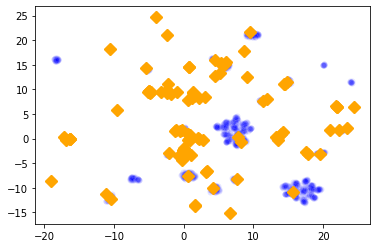

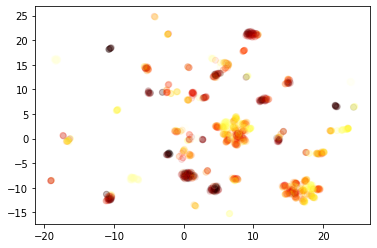

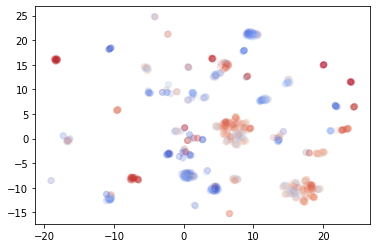

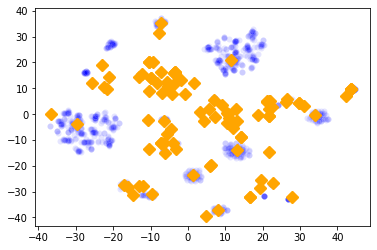

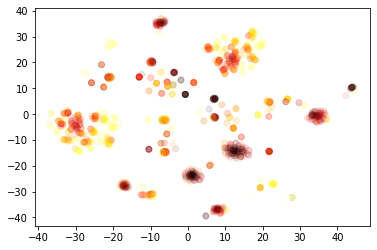

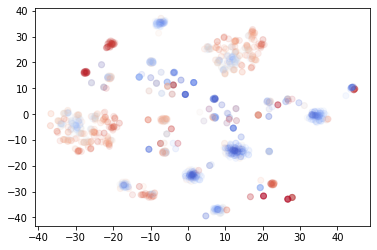

In [90]:
import seaborn as sns
for name, coords in zip(
            ['umap', 'tsne' ],
            [ X_umap, X_tsne ],
    ):
    # distinguish training from mutants
    plt.figure()
    sns.scatterplot(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                        color='blue', alpha=0.1,)
    plt.scatter(x=coords[labels == 0, 0], y=coords[labels == 0, 1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)
    # visualise mutant based on the acquisition (ranks)
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=acquisition_unk, alpha=0.1, cmap='hot')
    # visualize the mutant based on the rank data of the GP variances (uncertainty)
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=ss.rankdata(y_var_mut), alpha=0.1, cmap='coolwarm')

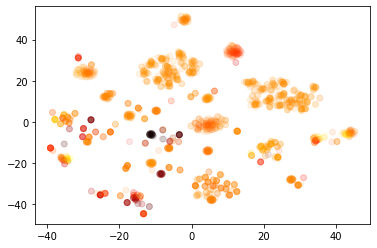

In [57]:
# label points in the TSNE so that Kd and rank info can be accessed
plt.figure()
plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                c=-acquisition_unk, alpha=0.1, cmap='hot')
plt.show()

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from MulticoreTSNE import MulticoreTSNE as TSNE
# Given observed data (obs_data) and unknown data (unknown_data)

# 1. Find nearest neighbors for each unknown point using observed data.
nbrs = NearestNeighbors(n_neighbors=1).fit(x_train_wt_array)
_, indices = nbrs.kneighbors(unknown_array)
tsne = TSNE(
        n_components=2,
        n_jobs=20,
    )

# 2. Apply t-SNE on the combined data
combined_data = np.vstack([x_train_wt_array, unknown_array])
tsne_results = tsne.fit_transform(combined_data)

# Split the t-SNE results back into observed and unknown parts
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

In [109]:
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

In [110]:
x_train_wt_array

array([[ 0.023891  , -0.03831439, -0.07290564, ..., -0.22226152,
         0.02643499,  0.11225177],
       [ 0.0240121 ,  0.00367938,  0.02346238, ..., -0.24938402,
         0.11721389,  0.16941018],
       [ 0.05326403,  0.04403213, -0.0232374 , ..., -0.1735692 ,
        -0.04422903,  0.23135675],
       ...,
       [-0.07817758, -0.02313735, -0.0655627 , ..., -0.22081426,
         0.0263268 ,  0.12111432],
       [-0.01302454, -0.07257082, -0.01249163, ..., -0.03220332,
        -0.03510378,  0.05690523],
       [ 0.0280782 ,  0.00933257,  0.04690858, ..., -0.24938402,
         0.11721389,  0.16941018]], dtype=float32)

/opt/rh/rh-python38/root/usr/local/lib64/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


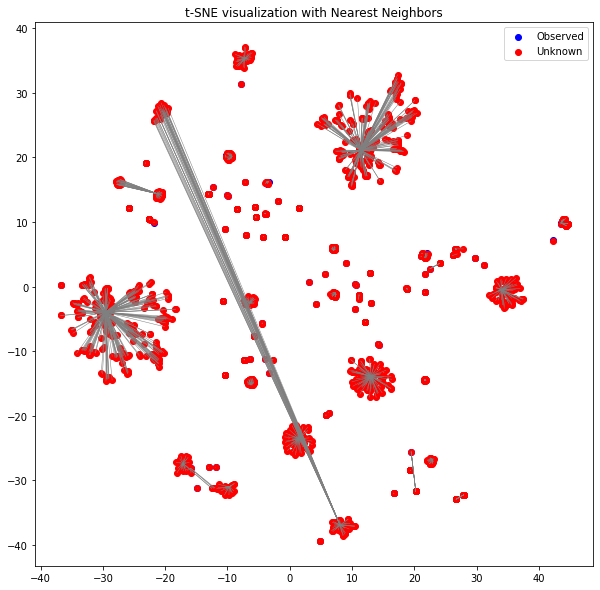

In [111]:

# 3. Plot
plt.figure(figsize=(10, 10))

# Plot observed points in blue
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='blue', label='Observed')

# Plot unknown points in red
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='red', label='Unknown')

# Draw lines between each unknown point and its nearest observed neighbor
for i, index in enumerate(indices):
    plt.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("t-SNE visualization with Nearest Neighbors")
plt.show()

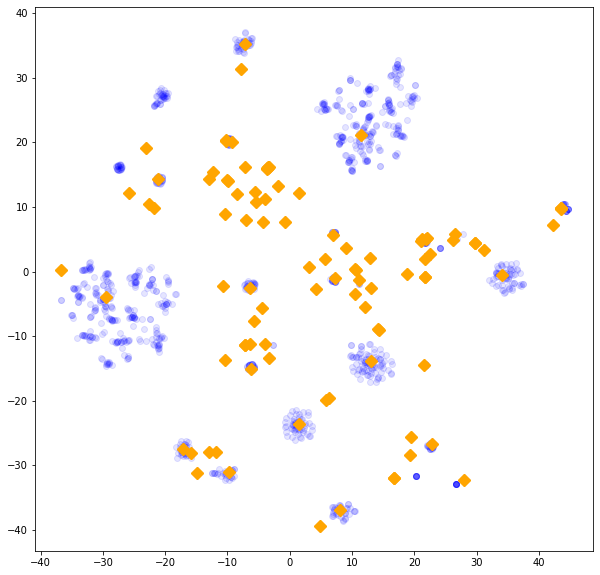

In [112]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_unknown[:,0], tsne_unknown[:,1], color='blue', alpha=0.1,)
plt.scatter(tsne_obs[:,0], tsne_obs[:,1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)